# Description

## LOGISTIC REGRESSION

Problem Statement : "You have a telecom firm which has collected data of all its customers" The main types of attributes are : 1.Demographics (age, gender etc.) 2.Services availed (internet packs purchased, special offers etc) 3.Expenses (amount of recharge done per month etc.) Based on all this past information, you want to build a model which will predict whether a particular customer will churn or not. So the variable of interest, i.e. the target variable here is ‘Churn’ which will tell us whether or not a particular customer has churned. It is a binary variable 1 means that the customer has churned and 0 means the customer has not churned. With 21 predictor variables we need to predict whether a particular customer will switch to another telecom provider or not.

PROCEDURE Import the required libraries 1. Importing all datasets 2. Merging all datasets based on condition ("customer_id ") 3. Data Cleaning - checking the null values 4. Check for the missing values and replace them 5. Model building • Binary encoding • One hot encoding • Creating dummy variables and removing the extra columns

    1. Feature selection using RFE - Recursive Feature Elimination
    2. Getting the predicted values on train set
    3. Creating a new column predicted with 1 if churn > 0.5 else 0
    4. Create a confusion matrix on train set and test
    5. Check the overall accuracy
    
https://www.kaggle.com/dileep070/logisticregression-telecomcustomer-churmprediction/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix

df1 = pd.read_csv('logistic_reg/customer_data.csv')
df2 = pd.read_csv('logistic_reg/internet_data.csv')
df3 = pd.read_csv('logistic_reg/churn_data.csv')

df = pd.concat([df1, df2, df3], axis=1)
df = df.loc[:,~df.columns.duplicated()]
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,No phone service,DSL,No,Yes,No,...,No,No,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,No,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,...,No,No,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,No phone service,DSL,Yes,No,Yes,...,No,No,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,...,No,No,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'tenure', 'PhoneService', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

## Encoding categorical variables
The categorical variables here are all binary. So get_dummies method of pandas is used which creates new columns with specific category of the variable and previous col is dropped

In [3]:
# Encoding categorical values
df_req = df.drop(['customerID','TotalCharges'], axis=1)
df_new = pd.get_dummies(df_req, prefix_sep='_', drop_first=True)
data = pd.concat([df[['customerID','TotalCharges']] ,df_new], axis=1)
data.head()

,customerID,TotalCharges,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_No internet service,StreamingMovies_Yes,PhoneService_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,7590-VHVEG,29.85,0,1,29.85,0,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,1889.5,0,34,56.95,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2,3668-QPYBK,108.15,0,2,53.85,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
3,7795-CFOCW,1840.75,0,45,42.30,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,151.65,0,2,70.70,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1


## Category-wise count
Counts of people who churned and those who didnt

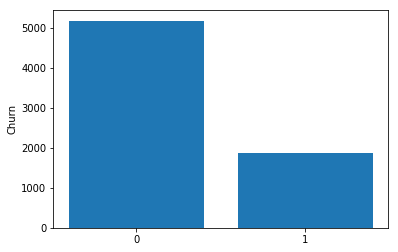

In [4]:
labels = list(data['Churn_Yes'].unique())
values = list(data['Churn_Yes'].value_counts())

fig, ax = plt.subplots()

ax.bar(labels, values)
ax.set_xticks(labels)
ax.set_ylabel('Churn')
plt.show()

## Data Transformation
Empty/null values are handled

In [5]:
data['TotalCharges'].replace(" ", np.nan, inplace=True)
data.dropna(subset=['TotalCharges'], inplace=True)

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
data.head()

,customerID,TotalCharges,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_No internet service,StreamingMovies_Yes,PhoneService_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,7590-VHVEG,29.85,0,1,29.85,0,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,1889.50,0,34,56.95,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2,3668-QPYBK,108.15,0,2,53.85,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,1
3,7795-CFOCW,1840.75,0,45,42.30,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,151.65,0,2,70.70,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1


## Feature Selection using RFE
25 most useful features are selected by Recursive Feature Elimination

In [6]:
X = data.drop(['customerID', 'Churn_Yes'], axis=1)
y = data['Churn_Yes']

In [7]:
# Using RFE for feature selection

logReg = LogisticRegression(solver='liblinear')

rfe = RFE(logReg, 25)
rfe = rfe.fit(X, y)

# Selected Features by Recursive Feature Elimination
feature_cols = [a for a,b in zip(X.columns.values, rfe.support_) if b==True]
feature_cols

['SeniorCitizen',
 'tenure',
 'gender_Male',
 'Dependents_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'PhoneService_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check']

## Model Building
Building model using Logistic Regression

In [8]:
# Model Fitting
X = X[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [9]:
# Accuracy
y_pred = logreg.predict(X_test)
logreg.score(X_test, y_test)

0.8117178612059158

## Confusion Matrix
Confusion Matrix to get count of correct and wrong predictions

In [10]:
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat

array([[1186,  124],
       [ 207,  241]])

In [11]:
tp = confusion_mat[0][0]
fn = confusion_mat[0][1]
fp = confusion_mat[1][0]
tn = confusion_mat[1][1]

print('True Positives = ' + str(tp))
print('False Negatives = ' + str(fn))
print('False Positives = ' + str(fp))
print('True Negatives = ' + str(tn))
print()
print('Correct predictions: ' + str(tp+tn))
print('Wrong predictions: '+ str(fp+fn))

True Positives = 1186
False Negatives = 124
False Positives = 207
True Negatives = 241

Correct predictions: 1427
Wrong predictions: 331
